In [1]:
import cftime
import cartopy.crs as ccrs
import cartopy.geodesic
import cartopy.feature as cf
import dask
from IPython.display import clear_output
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import pandas as pd
import xarray as xr
import easygems.healpix as egh
import intake
import warnings
from cartopy.io import DownloadWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DownloadWarning)
mpl.rcParams['figure.dpi'] = 72  # set figure resolution to reduce file size

# use for javascript animation:
plt.rcParams["animation.html"] = "jshtml"

In [2]:
# load the NERSC catalog
current_location = "NERSC"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]
list(cat)

['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'nicam_220m_test',
 'nicam_gl11',
 'scream-dkrz',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'scream_ne120_inst',
 'tracking',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3',
 'wrf_conus',
 'wrf_samerica']

### Choose a Data Set
Use `.describe()` on a dateset to see the other parameter options (we use `pandas` just for concise output formatting)

In [3]:
pd.DataFrame(cat["scream2D_hrly"].describe()["user_parameters"])

,name,description,type,allowed,default
0,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",2


### Load SCREAM data
We will use `zoom` level 9 [(~12km)](https://easy.gems.dkrz.de/Processing/healpix/index.html#healpix-spatial-resolution) that contains hourly OLR & precipitation, which was used in the MCS tracking.

In [4]:
scream2D_hrly = cat["scream2D_hrly"](zoom=9).to_dask() 
scream2D_hrly

<xarray.Dataset> Size: 238GB
Dimensions:   (crs: 0, time: 9457, cell: 3145728)
Coordinates:
  * crs       (crs) float64 0B 
  * time      (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
Dimensions without coordinates: cell
Data variables:
    pr        (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    rlut      (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    ELEV      (cell) float32 13MB dask.array<chunksize=(4096,), meta=np.ndarray>
    LANDFRAC  (cell) float32 13MB dask.array<chunksize=(4096,), meta=np.ndarray>
    lat       (cell) float32 13MB dask.array<chunksize=(4096,), meta=np.ndarray>
    lon       (cell) float32 13MB dask.array<chunksize=(4096,), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

### Load HEALPix MCS mask

- The HEALPix MCS mask data is in the SCREAM catalog
- The MCS tracks data (netCDF) is available via [Globus](https://app.globus.org/file-manager?origin_id=41bda5dc-c193-43e8-a922-0fe4f94490e7&origin_path=%2Ftracking%2Fmcs%2Fscream%2Fstats%2F&two_pane=true): `mcs_tracks_final_20190801.0000_20200901.0000.nc`

In [5]:
pd.DataFrame(cat["tracking"].describe()["user_parameters"])

,name,description,type,allowed,default
0,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6]",9


In [6]:
# Read MCS mask data from the catalog:
dsmask = cat["tracking"](zoom=9).to_dask()
dsmask

<xarray.Dataset> Size: 476GB
Dimensions:   (time: 9456, cell: 3145728)
Coordinates:
  * cell      (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    crs       int64 8B ...
  * time      (time) datetime64[ns] 76kB 2019-08-01T01:00:00 ... 2020-09-01
Data variables:
    ccs_mask  (time, cell) float64 238GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    mcs_mask  (time, cell) float64 238GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
Attributes: (12/15)
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Mon May  5 10:42:36 2025
    Institution:               Pacific Northwest National Laboratory
    Title:                     HEALPix remapped tracking mask data (zoom=9)
    linkpf:                    1
    minimum_cloud_area:        800
    ...                        ...
    pf_smooth_window:          5
    tb_threshold_coldanvil:    241.0
    tb_threshold_core:         225.0
    tb_threshold_environment:  261.0
    tb_threshold_warmanvil:    261.0
    zoom:                      9

### Load NetCDF tracks

In [7]:
# MCS tracks data
statsdir = "/global/cfs/cdirs/m4581/gsharing/hackathon/tracking/mcs/scream/stats/"
stats_file = f"{statsdir}mcs_tracks_final_20190801.0000_20200901.0000.nc"
stats_file

'/global/cfs/cdirs/m4581/gsharing/hackathon/tracking/mcs/scream/stats/mcs_tracks_final_20190801.0000_20200901.0000.nc'

In [8]:
# Read the MCS tracks data
dstracks = xr.open_dataset(
    stats_file, 
    mask_and_scale=True)
dstracks
# Each seperate file for each year defines its own index for tracks. Re-index with a global index.
# dstracks["tracks"] = np.arange(0, dstracks.dims["tracks"], 1, dtype=int)

<xarray.Dataset> Size: 58GB
Dimensions:                  (tracks: 56487, times: 650, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 452kB 0 1 2 3 ... 56484 56485 56486
  * times                    (times) int64 5kB 0 1 2 3 4 ... 645 646 647 648 649
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/63)
    track_duration           (tracks) int32 226kB ...
    start_status             (tracks) float64 452kB ...
    end_status               (tracks) float64 452kB ...
    start_basetime           (tracks) datetime64[ns] 452kB ...
    end_basetime             (tracks) datetime64[ns] 452kB ...
    start_split_cloudnumber  (tracks) float64 452kB ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 294MB ...
    movement_distance        (tracks, times) float32 147MB ...
    movement_speed           (tracks, times) float32 147MB ...
    movement_theta           (tracks, times) float32 147MB ...
    movement_distance_x      (tracks, times) float32 147MB ...
    movement_distance_y      (tracks, times) float32 147MB ...
Attributes: (12/21)
    Title:                        Statistics of each MCS track
    Institution:                  Pacific Northwest National Laboratory
    Contact:                      Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                   Mon May  5 11:14:12 2025
    startdate:                    20190801.0000
    enddate:                      20200901.0000
    ...                           ...
    MCS_PF_majoraxis_thresh:      0
    MCS_PF_duration_thresh:       4
    PF_PF_min_majoraxis_thresh:   20
    mcs_min_rainvol_thresh:       20000
    mcs_volrain_duration_thresh:  1.0
    max_speed_thresh:             50

In [9]:
# # Check if the dataset uses dask
# print(f"Dataset uses dask: {dstracks.chunks is not None}")

# # Check if variables are dask arrays
# for var_name in list(dstracks.data_vars)[:]:  # First 3 variables as example
#     print(f"Variable {var_name} is dask array: {isinstance(dstracks[var_name].data, dask.array.Array)}")

In [10]:
# The times have a small offset from the exact times -- e.g. 34500 ns off. Correct this.
# This mostly applies to the satellite data
def round_times_to_nearest_second(dstracks, fields):
    def remove_time_incaccuracy(t):
        # To make this an array operation, you have to use the ns version of datetime64, like so:
        return (np.round(t.astype(int) / 1e9) * 1e9).astype("datetime64[ns]")

    for field in fields:
        dstracks[field].load()
        tmask = ~np.isnan(dstracks[field].values)
        dstracks[field].values[tmask] = remove_time_incaccuracy(
            dstracks[field].values[tmask]
        )

round_times_to_nearest_second(dstracks, ['base_time', 'start_basetime', 'end_basetime'])

### Selecting tracks

In [11]:
# You might want to select tracks based on e.g. the time at which they are active:
datetime = pd.Timestamp('2020-06-21 16:00').to_numpy()
# isel selects on index. The expression on the RHS collapses the 2D field of `base_time` into a 
# 1D boolean field that is true if *any* base_time for a given track matches `datetime`.
dstracks_at_time = dstracks.isel(
     tracks=(dstracks.base_time.values == datetime).any(axis=1)
)
dstracks_at_time

<xarray.Dataset> Size: 100MB
Dimensions:                  (tracks: 98, times: 650, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 784B 45725 45862 ... 46307 46308
  * times                    (times) int64 5kB 0 1 2 3 4 ... 645 646 647 648 649
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/63)
    track_duration           (tracks) int32 392B ...
    start_status             (tracks) float64 784B ...
    end_status               (tracks) float64 784B ...
    start_basetime           (tracks) datetime64[ns] 784B 2020-06-17T15:00:00...
    end_basetime             (tracks) datetime64[ns] 784B 2020-06-21T20:00:00...
    start_split_cloudnumber  (tracks) float64 784B ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 510kB ...
    movement_distance        (tracks, times) float32 255kB ...
    movement_speed           (tracks, times) float32 255kB ...
    movement_theta           (tracks, times) float32 255kB ...
    movement_distance_x      (tracks, times) float32 255kB ...
    movement_distance_y      (tracks, times) float32 255kB ...
Attributes: (12/21)
    Title:                        Statistics of each MCS track
    Institution:                  Pacific Northwest National Laboratory
    Contact:                      Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                   Mon May  5 11:14:12 2025
    startdate:                    20190801.0000
    enddate:                      20200901.0000
    ...                           ...
    MCS_PF_majoraxis_thresh:      0
    MCS_PF_duration_thresh:       4
    PF_PF_min_majoraxis_thresh:   20
    mcs_min_rainvol_thresh:       20000
    mcs_volrain_duration_thresh:  1.0
    max_speed_thresh:             50

In [12]:
# Or access tracks based on their location:
# N.B. force a load of meanlat.
dstracks.meanlat.load()
# This suppresses a warning about chunk sizes.
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    dstracks_michigan = dstracks.isel(
        tracks=(
            (dstracks.meanlat.values > 41) & (dstracks.meanlat.values < 48) & (dstracks.meanlon.values > -89) & (dstracks.meanlon.values < -82)
        ).any(axis=1)
    )
dstracks_michigan

<xarray.Dataset> Size: 172MB
Dimensions:                  (tracks: 168, times: 650, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 1kB 882 900 995 ... 56258 56396
  * times                    (times) int64 5kB 0 1 2 3 4 ... 645 646 647 648 649
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/63)
    track_duration           (tracks) int32 672B ...
    start_status             (tracks) float64 1kB ...
    end_status               (tracks) float64 1kB ...
    start_basetime           (tracks) datetime64[ns] 1kB 2019-08-05T22:00:00 ...
    end_basetime             (tracks) datetime64[ns] 1kB 2019-08-07T12:00:00 ...
    start_split_cloudnumber  (tracks) float64 1kB ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 874kB ...
    movement_distance        (tracks, times) float32 437kB ...
    movement_speed           (tracks, times) float32 437kB ...
    movement_theta           (tracks, times) float32 437kB ...
    movement_distance_x      (tracks, times) float32 437kB ...
    movement_distance_y      (tracks, times) float32 437kB ...
Attributes: (12/21)
    Title:                        Statistics of each MCS track
    Institution:                  Pacific Northwest National Laboratory
    Contact:                      Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                   Mon May  5 11:14:12 2025
    startdate:                    20190801.0000
    enddate:                      20200901.0000
    ...                           ...
    MCS_PF_majoraxis_thresh:      0
    MCS_PF_duration_thresh:       4
    PF_PF_min_majoraxis_thresh:   20
    mcs_min_rainvol_thresh:       20000
    mcs_volrain_duration_thresh:  1.0
    max_speed_thresh:             50

### Individual track properties

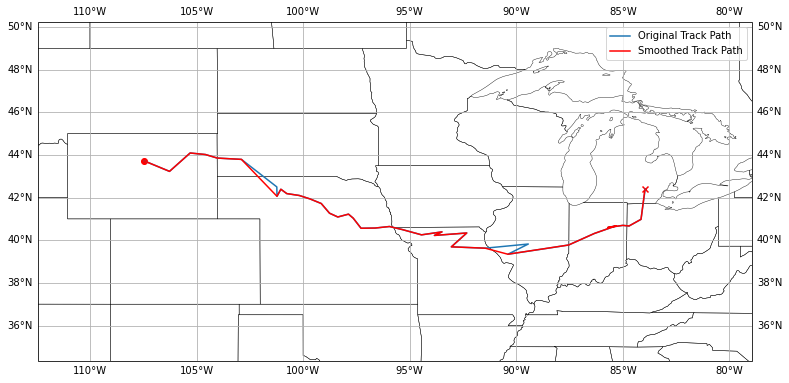

In [13]:
def PlotTrack(MyAx, track_dataset, track_index, global_extent=False):
    track = track_dataset.isel(tracks=track_index)
    duration = track.track_duration.values.item()
    margin = 5
    extent = track.meanlon.min().item() - margin, track.meanlon.max().item() + margin, track.meanlat.min().item() - margin, track.meanlat.max().item() + margin
    
    if global_extent==True:
        ax.set_global()
    else: 
        ax.set_extent(extent)

    ax.coastlines()
    ax.add_feature(cf.STATES, linewidth=0.4)
    ax.gridlines(draw_labels=True)

    # plot start and end points
    ax.scatter(track.meanlon.values[0], track.meanlat.values[0], marker='o', color='r', transform=ccrs.PlateCarree())  # Start point.
    ax.scatter(track.meanlon.values[duration - 1], track.meanlat.values[duration - 1], marker='x', color='r', transform=ccrs.PlateCarree())  # End point.
    
    # plot the track:
    plt.plot(track.meanlon.values, track.meanlat.values, label='Original Track Path')
    
    # plot the smoothed track
    lon_s = track.meanlon_smooth
    lat_s = track.meanlat_smooth
    
    plt.plot(lon_s, lat_s, color='red', label='Smoothed Track Path')
    plt.legend()

plt.figure(1, figsize=(12.8, 9.6))
ax = plt.axes(projection=ccrs.PlateCarree())
PlotTrack(ax, dstracks_michigan, 0)

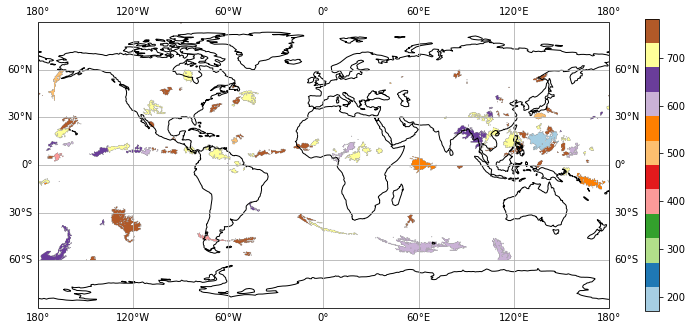

In [14]:
plt.figure(2, figsize=(12.8, 9.6))
ax2 = plt.axes(projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_global()
ax2.gridlines(draw_labels=True)
mcs_mask = dsmask.isel(time=100).mcs_mask
img = egh.healpix_show(mcs_mask.where(mcs_mask!=0), ax=ax2, cmap='Paired')
plt.colorbar(img, shrink=0.55)

### Testing

In [15]:
mcs_mask = dsmask.mcs_mask
mcs_mask

<xarray.DataArray 'mcs_mask' (time: 9456, cell: 3145728)> Size: 238GB
dask.array<open_dataset-mcs_mask, shape=(9456, 3145728), dtype=float64, chunksize=(24, 262144), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    crs      int64 8B ...
  * time     (time) datetime64[ns] 76kB 2019-08-01T01:00:00 ... 2020-09-01
Attributes:
    comments:   This mask renumbers small merge/split tracks to the main trac...
    long_name:  Track number including merge/split
    units:      unitless

In [16]:
mask_time = mcs_mask.time.values
mask_time

array(['2019-08-01T01:00:00.000000000', '2019-08-01T02:00:00.000000000',
       '2019-08-01T03:00:00.000000000', ...,
       '2020-08-31T22:00:00.000000000', '2020-08-31T23:00:00.000000000',
       '2020-09-01T00:00:00.000000000'],
      shape=(9456,), dtype='datetime64[ns]')

In [17]:
track_time = dstracks.isel(tracks=0).base_time
track_time

<xarray.DataArray 'base_time' (times: 650)> Size: 5kB
array(['2019-08-01T01:00:00.000000000', '2019-08-01T02:00:00.000000000',
       '2019-08-01T03:00:00.000000000', '2019-08-01T04:00:00.000000000',
       '2019-08-01T05:00:00.000000000', '2019-08-01T06:00:00.000000000',
       '2019-08-01T07:00:00.000000000', '2019-08-01T08:00:00.000000000',
       '2019-08-01T09:00:00.000000000', '2019-08-01T10:00:00.000000000',
       '2019-08-01T11:00:00.000000000', '2019-08-01T12:00:00.000000000',
       '2019-08-01T13:00:00.000000000', '2019-08-01T14:00:00.000000000',
       '2019-08-01T15:00:00.000000000', '2019-08-01T16:00:00.000000000',
       '2019-08-01T17:00:00.000000000', '2019-08-01T18:00:00.000000000',
       '2019-08-01T19:00:00.000000000', '2019-08-01T20:00:00.000000000',
       '2019-08-01T21:00:00.000000000', '2019-08-01T22:00:00.000000000',
       '2019-08-01T23:00:00.000000000', '2019-08-02T00:00:00.000000000',
       '2019-08-02T01:00:00.000000000', '2019-08-02T02:00:00.000000000',
       '2019-08-02T03:00:00.000000000', '2019-08-02T04:00:00.000000000',
       '2019-08-02T05:00:00.000000000', '2019-08-02T06:00:00.000000000',
       '2019-08-02T07:00:00.000000000', '2019-08-02T08:00:00.000000000',
       '2019-08-02T09:00:00.000000000', '2019-08-02T10:00:00.000000000',
       '2019-08-02T11:00:00.000000000',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
...
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT'],
      dtype='datetime64[ns]')
Coordinates:
    tracks   int64 8B 0
  * times    (times) int64 5kB 0 1 2 3 4 5 6 7 ... 643 644 645 646 647 648 649
Attributes:
    long_name:  Epoch time of a feature

In [18]:
mcs_mask.sel(time='2019-08-01T07:00:00.000000000')

<xarray.DataArray 'mcs_mask' (cell: 3145728)> Size: 25MB
dask.array<getitem, shape=(3145728,), dtype=float64, chunksize=(262144,), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    crs      int64 8B ...
    time     datetime64[ns] 8B 2019-08-01T07:00:00
Attributes:
    comments:   This mask renumbers small merge/split tracks to the main trac...
    long_name:  Track number including merge/split
    units:      unitless

### Code from demo

Original HEALPix time count: 9457
Matching times found: 9456
dsmask time count: 9456


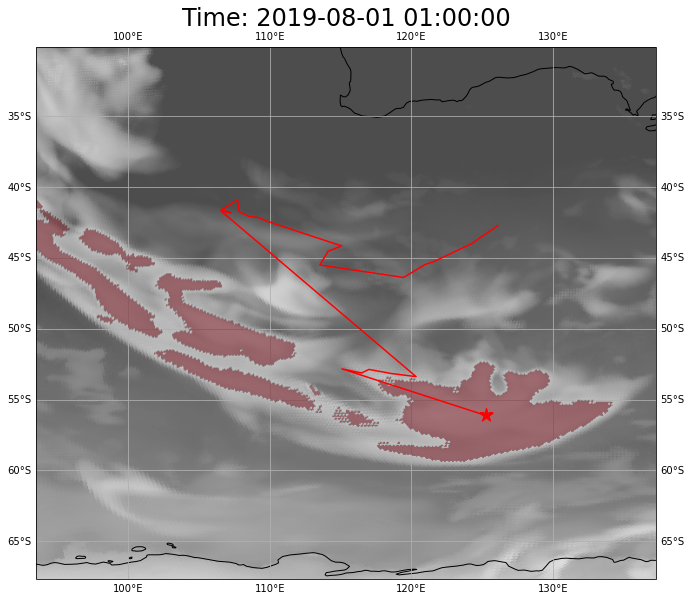

In [106]:
def convert_to_cftime(datetime, calendar):
    """
    Convert a pandas.Timestamp object to a cftime object based on the calendar type.
    Return pandas.Timestamp for standard calendars that don't need conversion.

    Args:
        datetime: pandas.Timestamp
            Timestamp object to convert.
        calendar: str
            Calendar type.

    Returns:
        cftime object.
    """
    # Standard/Gregorian/Proleptic Gregorian calendars can often use pandas Timestamps directly
    if calendar in ['proleptic_gregorian', 'gregorian', 'standard']:
        return datetime
    if calendar == 'noleap':
        return cftime.DatetimeNoLeap(datetime.year, datetime.month, datetime.day, datetime.hour, datetime.minute)
    elif calendar == '360_day':
        return cftime.Datetime360Day(datetime.year, datetime.month, datetime.day, datetime.hour, datetime.minute)
    else:
        raise ValueError(f"Unsupported calendar type: {calendar}")


def align_dataset(dshp, dsmask, track_dataset, track_index, MyAx, track_time_index=0, global_extent=False):
    track = track_dataset.isel(tracks=track_index)
    duration = track.track_duration.values.item()

    # Convert time components from datasets to deal with different calendars
    hp_times = [(t.year, t.month, t.day, t.hour) for t in dshp.time.values]
    mask_times = [(pd.Timestamp(t).year, pd.Timestamp(t).month, pd.Timestamp(t).day, pd.Timestamp(t).hour) for t in dsmask.time.values]
    
    # Find matching indices
    matching_indices = [i for i, t in enumerate(hp_times) if t in set(mask_times)]
    # Select using indices
    dshp_subset = dshp.isel(time=matching_indices)
    # Verify number of timestamps
    print(f"Original HEALPix time count: {dshp.time.size}")
    print(f"Matching times found: {len(matching_indices)}")
    print(f"dsmask time count: {dsmask.time.size}")
    
    # Create a new dsmask with the time coordinate from dshp_subset
    dsmask_ = dsmask.copy()
    
    # Replace the time coordinate with the matching times from dshp_subset
    # This must maintain the same order as in the original dsmask
    dsmask_ = dsmask_.assign_coords(time=dshp_subset.time.values)
    
    # Combine the datasets
    ds = xr.merge([dshp_subset, dsmask_], combine_attrs='drop_conflicts')
    
    # Rechunk the dataset to match the mask
    ds = ds.chunk(dict(dsmask_.chunks))
    
    # These can be used to work out which pixel-level data to locate the times.
    calendar = ds['time'].dt.calendar
    
    base_times = track.base_time.values[:duration]
    track_dates = [convert_to_cftime(pd.Timestamp(d).to_pydatetime(), calendar) for d in base_times]
    
    # Track number in the mask file is +1 offset to the track index in the stats file.
    track_number = track.tracks + 1

    # plotting
    margin = 10
    extent = track.meanlon.min().item() - margin, track.meanlon.max().item() + margin, track.meanlat.min().item() - margin, track.meanlat.max().item() + margin
    my_time = track_dates[track_time_index]
    ds_at_time_index = ds.sel(time=my_time)
    MyAx.coastlines()
    MyAx.gridlines(draw_labels=True, zorder=5)
    plt.title(f'Time: {my_time}', fontsize=24)

    if global_extent==True:
        MyAx.set_global()
    else: 
        MyAx.set_extent(extent)

    # mask
    mask = ds_at_time_index.mcs_mask
    mask = mask.where(mask == track_number, np.nan)  # only the MCS is 1, rest is NaN
    im_mask = egh.healpix_show(mask, ax=MyAx, cmap='Reds', vmin=1, vmax=1.01, alpha=0.5, zorder=2)

    # track
    lon_s = track.meanlon_smooth
    lat_s = track.meanlat_smooth
    
    plt.plot(lon_s, lat_s, color='red', label='Smoothed Track Path', zorder=3)
    MyAx.scatter(track.meanlon.values[track_time_index], track.meanlat.values[track_time_index], s=200, marker='*', c='red', zorder=4)

    # OLR
    im_rlut = egh.healpix_show(ds_at_time_index.rlut, ax=MyAx, vmin=80, vmax=260, cmap=mpl.colormaps.get_cmap('Greys'), alpha=0.7, zorder=1)

    return ds, track_number, the_mcs_mask

plt.figure(2, figsize=(12.8, 9.6))
ax2 = plt.axes(projection=ccrs.PlateCarree())
ds_align, track_number, the_mcs_mask = align_dataset(scream2D_hrly, dsmask, dstracks, 2, ax2, global_extent=False)